# Import needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams.update({'figure.dpi': 120,'figure.figsize': (6,4)}) 

from pyQME.spectral_density import SpectralDensity
from pyQME.linear_spectra import LinearSpectraCalculator
from pyQME.tensors import RedfieldForsterTensorReal
from pyQME.utils import overdamped_brownian,underdamped_brownian,get_timeaxis,wn2ips,partition_by_clusters,clusterize_popt,gauss_pulse,calc_rho0_from_overlap

# Define the system

**Hamiltonian (1/cm)**

In [2]:
nchrom = 3 #numero di cromofori

E0 = 10000
energy_gap = 100
coupling_12 = 100
coupling_23 = 30
coupling_13 = 10
H = np.zeros((nchrom,nchrom)) #hamiltonian

H[0] = np.asarray([E0          , coupling_12     , coupling_13     ])
H[1] = np.asarray([coupling_12 , E0+energy_gap   , coupling_23     ])
H[2] = np.asarray([coupling_13 , coupling_23     , E0+2*energy_gap ])

In [3]:
H

array([[1.00e+04, 1.00e+02, 1.00e+01],
       [1.00e+02, 1.01e+04, 3.00e+01],
       [1.00e+01, 3.00e+01, 1.02e+04]])

**Partitioning of the Hamiltonian**

In [4]:
clusters = [[0,1],[2]]

In [5]:
H_part,V = partition_by_clusters(H,cluster_list=clusters)

In [6]:
H_part

array([[10000.,   100.,     0.],
       [  100., 10100.,     0.],
       [    0.,     0., 10200.]])

In [7]:
V

array([[ 0.,  0., 10.],
       [ 0.,  0., 30.],
       [10., 30.,  0.]])

**Transition dipoles (Debye)**

In [8]:
dipoles = np.ones([nchrom,3])

**Temperature (Kelvin)**

In [9]:
temp = 298

**Spectral density**

In [10]:
freq_axis_SD = np.arange(0.1,4000,0.1)

In [11]:
SD_data = overdamped_brownian(freq_axis_SD,30,37)
SD_data = SD_data + underdamped_brownian(freq_axis_SD,5,50,1000)

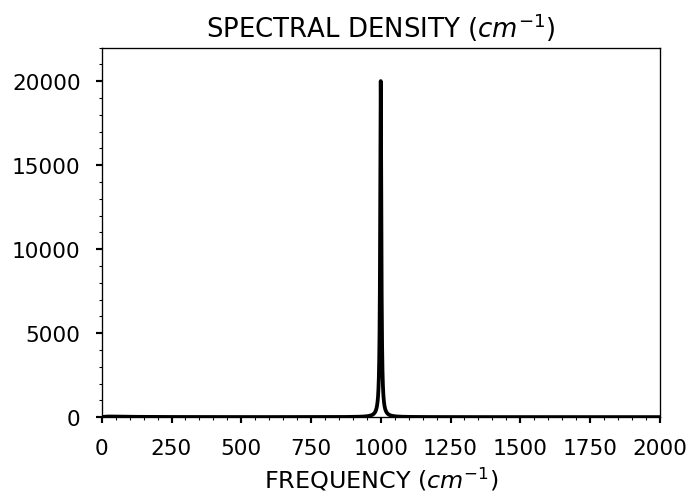

In [12]:
plt.plot(freq_axis_SD,SD_data,color='black');
plt.xlim(0,2000);
plt.ylim(0,22000)
plt.title('SPECTRAL DENSITY ($cm^{-1}$)');
plt.xlabel('FREQUENCY ($cm^{-1}$)');
plt.minorticks_on()

In [13]:
SD_obj = SpectralDensity(freq_axis_SD,SD_data,temperature=temp)

**Time axis (cm)**

In [14]:
energies = np.diag(H)
time_axis = get_timeaxis(SD_obj.Reorg,energies,5)
SD_obj.time = time_axis

**Relaxation Tensor (Complex Redfield)**

In [15]:
rel_tens_obj = RedfieldForsterTensorReal(H_part,V,SD_obj)

# Excited state dynamics

**Time axis**

In [16]:
time_axis_ps = np.arange(0,3.,0.1)
time_axis_cm = time_axis_ps*wn2ips

**Initial density matrix**

In [17]:
#absorption spectrum of each exciton

lin_spec_obj = LinearSpectraCalculator(rel_tens_obj,include_dephasing=True)
freq_axis,OD_a = lin_spec_obj.calc_OD_a(dipoles)

In [18]:
#generate the pump pulse
pump = gauss_pulse(freq_axis,10200,100,2000000)

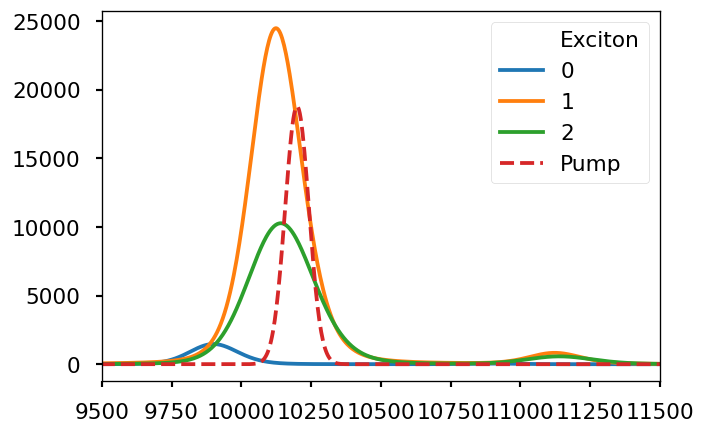

In [19]:
#visualize the overlap
plt.plot([],[],color='white',label='Exciton')
plt.plot(freq_axis,OD_a.T,label=range(nchrom))
plt.plot(freq_axis,pump,ls='--',label='Pump')
plt.legend();
plt.xlim(9500,11500);

In [20]:
#calculate the overlap and the initial density matrix
rho_0_exc = calc_rho0_from_overlap(freq_axis,OD_a,pump)

#normalize
rho_0_exc = rho_0_exc/rho_0_exc.trace()

**Propagate**

In [21]:
rho_t_exc = rel_tens_obj.propagate(rho_0_exc,time_axis_cm)

#convert to site basis
rho_t_site = rel_tens_obj.transform_back(rho_t_exc)

pop_t_site = np.einsum('tkk->tk',rho_t_site).real

#clusterize
pop_t_cluterized = clusterize_popt(pop_t_site,clusters)

# Check the results

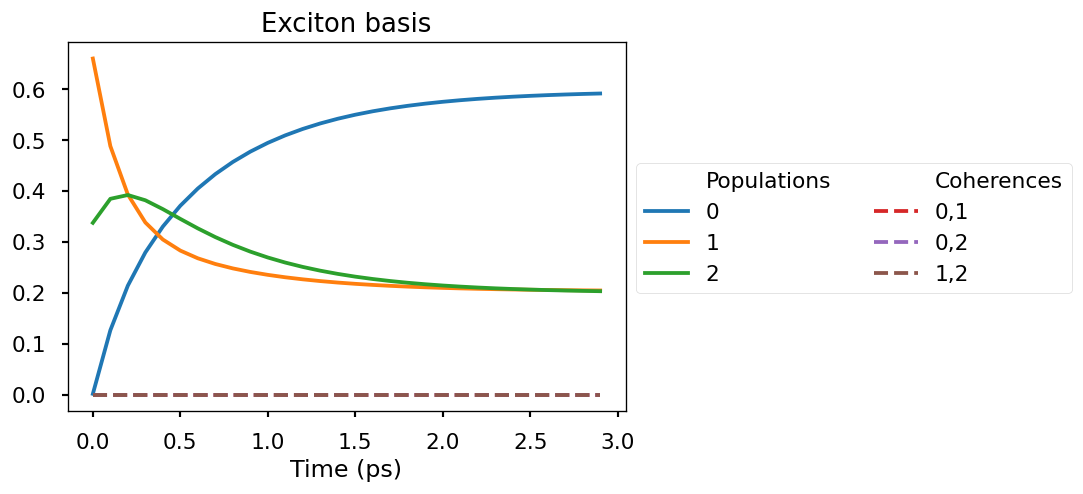

In [22]:
plt.title('Exciton basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,rho_t_exc[:,0,0].real,label = '0')
plt.plot(time_axis_ps,rho_t_exc[:,1,1].real,label = '1')
plt.plot(time_axis_ps,rho_t_exc[:,2,2].real,label = '2')
plt.plot([],[],color='white',label='Coherences')
plt.plot(time_axis_ps,rho_t_exc[:,0,1].real,label = '0,1',ls='--')
plt.plot(time_axis_ps,rho_t_exc[:,0,2].real,label = '0,2',ls='--')
plt.plot(time_axis_ps,rho_t_exc[:,1,2].real,label = '1,2',ls='--')
plt.legend(ncol=2,fontsize = 13,bbox_to_anchor = (1.0,0.7))
plt.xlabel('Time (ps)');

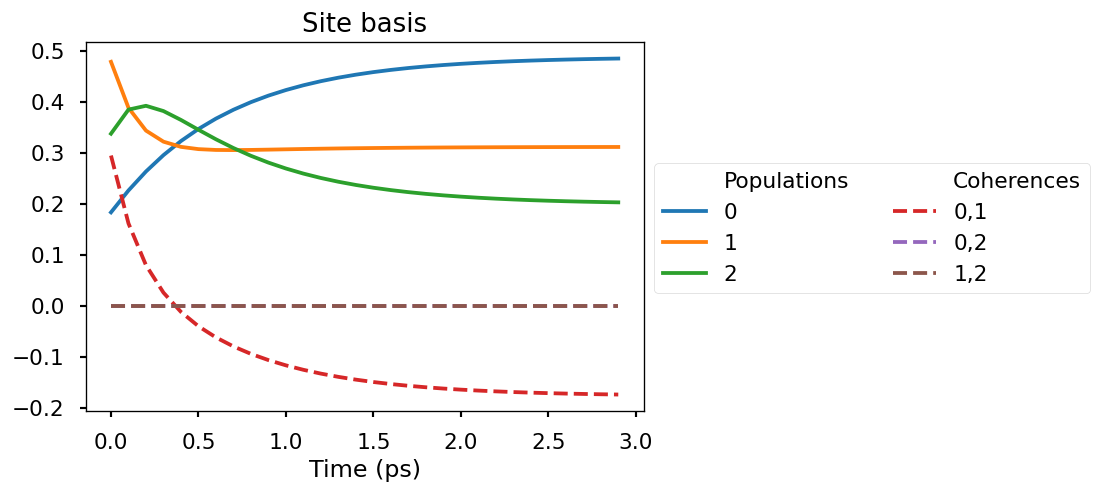

In [23]:
plt.title('Site basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,rho_t_site[:,0,0].real,label = '0')
plt.plot(time_axis_ps,rho_t_site[:,1,1].real,label = '1')
plt.plot(time_axis_ps,rho_t_site[:,2,2].real,label = '2')
plt.plot([],[],color='white',label='Coherences')
plt.plot(time_axis_ps,rho_t_site[:,0,1].real,label = '0,1',ls='--')
plt.plot(time_axis_ps,rho_t_site[:,0,2].real,label = '0,2',ls='--')
plt.plot(time_axis_ps,rho_t_site[:,1,2].real,label = '1,2',ls='--')
plt.legend(ncol=2,fontsize = 13,bbox_to_anchor = (1.0,0.7))
plt.xlabel('Time (ps)');

Text(0, 0.5, 'Populations')

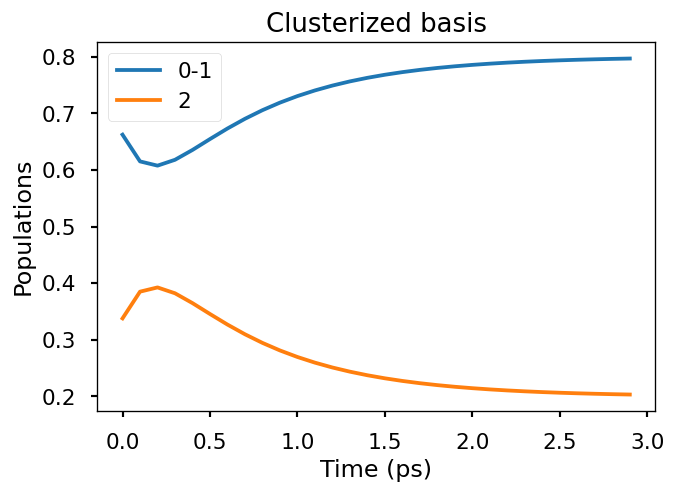

In [24]:
plt.title('Clusterized basis')
plt.plot(time_axis_ps,pop_t_cluterized[:,0].real,label = '0-1')
plt.plot(time_axis_ps,pop_t_cluterized[:,1].real,label = '2')
plt.legend(fontsize = 13)
plt.xlabel('Time (ps)');
plt.ylabel('Populations')

**Save to file for future pump-probe spectra calculations**

In [25]:
time_axis_ps

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9])

In [26]:
#select delay time of interest
time_list = [0.,0.2,2.9]
time_list_idx = [min(range(len(time_axis_ps)), key=lambda i: abs(time_axis_ps[i]-time)) for time in time_list]
mask = np.zeros(time_axis_ps.shape,bool)
mask[time_list_idx] = True
time_axis_ps_masked = time_axis_ps[mask]
rho_t_site_masked = rho_t_site[mask]

In [27]:
rho_t_site_masked_ = rho_t_site_masked.reshape((time_axis_ps_masked.size,nchrom**2))
data = np.append(np.asarray([time_axis_ps_masked]).T,rho_t_site_masked_,axis=1).real
np.savetxt('excited_state_dynamics.dat',data,fmt='%3.7f')